In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
df=pd.read_csv('./INFY.csv',index_col='Date',parse_dates=True)

Data Pre processing


In [3]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,INFOSYSTCH,EQ,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,NaN,NaN,NaN
2000-01-04,INFOSYSTCH,EQ,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,NaN,NaN,NaN
2000-01-05,INFOSYSTCH,EQ,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,NaN,NaN,NaN
2000-01-06,INFOSYSTCH,EQ,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,NaN,NaN,NaN
2000-01-07,INFOSYSTCH,EQ,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,INFY,EQ,1333.80,1332.25,1351.30,1321.00,1345.00,1343.55,1343.19,7088606,9.521361e+14,130375.0,4218129.0,0.5951
2021-04-27,INFY,EQ,1343.55,1346.00,1353.00,1340.15,1347.50,1348.50,1346.89,3636115,4.897445e+14,145974.0,1871084.0,0.5146
2021-04-28,INFY,EQ,1348.50,1358.00,1359.50,1344.60,1355.80,1356.00,1353.45,4879234,6.603778e+14,137376.0,2857134.0,0.5856


In [4]:
df['Date']=df.index

In [5]:
start_date='2016-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [6]:
df=df.loc[mask]

In [7]:
df=df.loc[mask]

In [8]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [9]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [10]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [11]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [12]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (1187, 50) Y.shape (1187,)


In [13]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

ANN

In [14]:
i=Input(shape=(T,))
x=Dense(400,activation='relu')(i)
x=Dense(100,activation='relu')(x)
x=Dense(50,activation='relu')(x)
x=Dense(1,activation='relu')(x)
model_ann=Model(i,x)
model_ann.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 400)               20400     
                                                                 
 dense_1 (Dense)             (None, 100)               40100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_ann.compile(
    loss='mse',
    optimizer='adamax',
    metrics='mae'
)

In [16]:
r=model_ann.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
26/26 [==============================] - 1s 8ms/step - loss: 802.4185 - mae: 11.2086 - val_loss: 331.7534 - val_mae: 12.2733
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 798.9891 - mae: 11.1403 - val_loss: 331.7534 - val_mae: 12.2733
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 798.8724 - mae: 11.1375 - val_loss: 331.7534 - val_mae: 12.2733
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 798.5438 - mae: 11.1273 - val_loss: 331.7534 - val_mae: 12.2733
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 798.3169 - mae: 11.1178 - val_loss: 331.7534 - val_mae: 12.2733
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 798.1255 - mae: 11.1057 - val_loss: 331.7534 - val_mae: 12.2733
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 797.9466 - mae: 11.0920 - val_loss: 331.7534 - val_mae: 12.2733
Epoch 8/100
26/26 [======================

CNN

In [17]:
i=Input(shape=(T,1))
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1)(x)
model_cnn=Model(i,x)
model_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 48, 25)            100       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 25)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                 51  

In [18]:
model_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [19]:
r=model_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
26/26 [==============================] - 1s 9ms/step - loss: 896.4323 - mae: 12.8732 - mse: 896.4323 - val_loss: 342.5221 - val_mae: 12.5512 - val_mse: 342.5221
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 814.1520 - mae: 11.4610 - mse: 814.1520 - val_loss: 345.2335 - val_mae: 12.6542 - val_mse: 345.2335
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 807.8840 - mae: 11.3676 - mse: 807.8840 - val_loss: 344.2815 - val_mae: 12.6386 - val_mse: 344.2815
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 805.2867 - mae: 11.3517 - mse: 805.2867 - val_loss: 343.4961 - val_mae: 12.6153 - val_mse: 343.4961
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 802.1783 - mae: 11.2902 - mse: 802.1783 - val_loss: 343.6241 - val_mae: 12.6264 - val_mse: 343.6241
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 801.5491 - mae: 11.3056 - mse: 801.5491 - val_loss: 345.0850 -

LSTM

In [20]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm=Model(i,x)
model_lstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 50, 200)           161600    
                                                                 
 lstm_1 (LSTM)               (None, 50, 200)           320800    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                           

In [21]:
check_point_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [22]:
model_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [23]:
r=model_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm]
)

Epoch 1/100
26/26 [==============================] - 8s 194ms/step - loss: 800.2259 - mae: 11.1638 - mse: 800.2259 - val_loss: 332.7559 - val_mae: 12.2961 - val_mse: 332.7559
Epoch 2/100
26/26 [==============================] - 4s 168ms/step - loss: 798.8430 - mae: 11.1559 - mse: 798.8430 - val_loss: 332.4846 - val_mae: 12.2733 - val_mse: 332.4846
Epoch 3/100
26/26 [==============================] - 4s 168ms/step - loss: 798.0463 - mae: 11.1480 - mse: 798.0463 - val_loss: 332.3647 - val_mae: 12.2567 - val_mse: 332.3647
Epoch 4/100
26/26 [==============================] - 4s 166ms/step - loss: 797.7756 - mae: 11.1397 - mse: 797.7756 - val_loss: 333.2822 - val_mae: 12.2793 - val_mse: 333.2822
Epoch 5/100
26/26 [==============================] - 4s 165ms/step - loss: 797.3199 - mae: 11.1374 - mse: 797.3199 - val_loss: 332.6855 - val_mae: 12.2566 - val_mse: 332.6855
Epoch 6/100
26/26 [==============================] - 4s 165ms/step - loss: 797.1695 - mae: 11.1592 - mse: 797.1695 - val_loss

GRU

In [24]:
i=Input(shape=(T,1))
x=GRU(200,return_sequences=True)(i)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_gru=Model(i,x)
model_gru.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe98b954ad0>>

In [25]:
check_point_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [26]:
model_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [27]:
r=model_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_gru]
)

Epoch 1/100
26/26 [==============================] - 7s 171ms/step - loss: 802.2381 - mae: 11.2118 - mse: 802.2381 - val_loss: 331.7118 - val_mae: 12.2797 - val_mse: 331.7118
Epoch 2/100
26/26 [==============================] - 4s 148ms/step - loss: 799.6040 - mae: 11.1877 - mse: 799.6040 - val_loss: 331.9314 - val_mae: 12.2689 - val_mse: 331.9314
Epoch 3/100
26/26 [==============================] - 4s 144ms/step - loss: 797.1287 - mae: 11.1588 - mse: 797.1287 - val_loss: 332.4437 - val_mae: 12.2707 - val_mse: 332.4437
Epoch 4/100
26/26 [==============================] - 4s 147ms/step - loss: 796.8750 - mae: 11.1512 - mse: 796.8750 - val_loss: 334.7195 - val_mae: 12.3454 - val_mse: 334.7195
Epoch 5/100
26/26 [==============================] - 4s 152ms/step - loss: 796.4236 - mae: 11.1526 - mse: 796.4236 - val_loss: 333.1686 - val_mae: 12.2850 - val_mse: 333.1686
Epoch 6/100
26/26 [==============================] - 4s 154ms/step - loss: 796.8217 - mae: 11.2464 - mse: 796.8217 - val_loss

Predictions

In [28]:
train_idx[:T+1]=False

In [29]:
Ptrain_ann=model_ann.predict(Xtrain).flatten()
Ptest_ann=model_ann.predict(Xtest).flatten()


In [30]:
Ptrain_cnn=model_cnn.predict(Xtrain).flatten()
Ptest_cnn=model_cnn.predict(Xtest).flatten()

In [31]:
Ptrain_lstm=model_lstm.predict(Xtrain).flatten()
Ptest_lstm=model_lstm.predict(Xtest).flatten()

In [32]:
Ptrain_gru=model_gru.predict(Xtrain).flatten()
Ptest_gru=model_gru.predict(Xtest).flatten()

In [33]:
df.loc[train_idx,'Diff ANN train prediction']=Ptrain_ann
df.loc[test_idx,'Diff ANN test prediction']=Ptest_ann

In [34]:
df.loc[train_idx,'Diff CNN train prediction']=Ptrain_cnn
df.loc[test_idx,'Diff CNN test prediction']=Ptest_cnn

In [35]:
df.loc[train_idx,'Diff LSTM train prediction']=Ptrain_lstm
df.loc[test_idx,'Diff LSTM test prediction']=Ptest_lstm

In [36]:
df.loc[train_idx,'Diff GRU train prediction']=Ptrain_gru
df.loc[test_idx,'Diff GRU test prediction']=Ptest_gru

In [37]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [38]:
last_train=train.iloc[-1]['Prev Close']

In [39]:
df.loc[train_idx,'train_ANN']=prev[train_idx]+Ptrain_ann
df.loc[test_idx,'Prediction_ANN']=prev[test_idx]+Ptest_ann

In [40]:
df.loc[train_idx,'train_CNN']=prev[train_idx]+Ptrain_cnn
df.loc[test_idx,'Prediction_CNN']=prev[test_idx]+Ptest_cnn

In [41]:
df.loc[train_idx,'train_LSTM']=prev[train_idx]+Ptrain_lstm
df.loc[test_idx,'Prediction_LSTM']=prev[test_idx]+Ptest_lstm

In [42]:
df.loc[train_idx,'train_GRU']=prev[train_idx]+Ptrain_gru
df.loc[test_idx,'Prediction_GRU']=prev[test_idx]+Ptest_gru

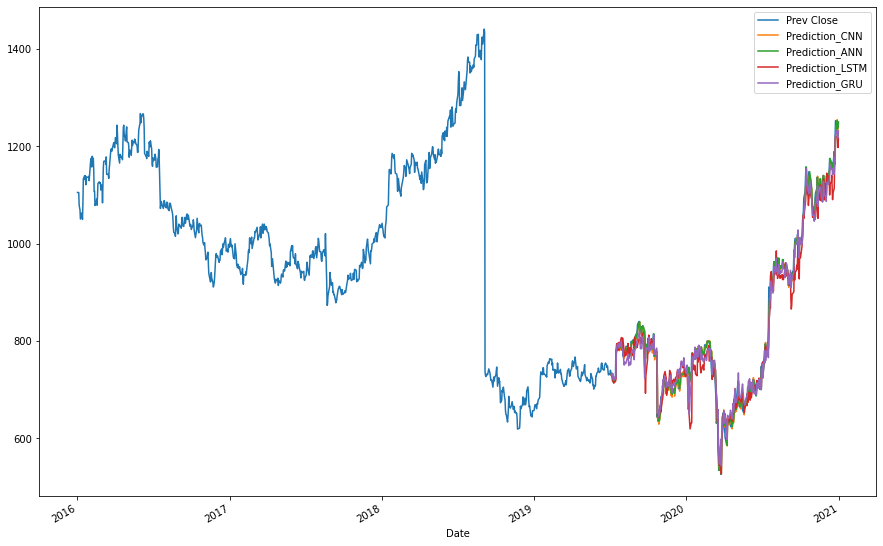

In [43]:
df[[ 'Prev Close','Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10));

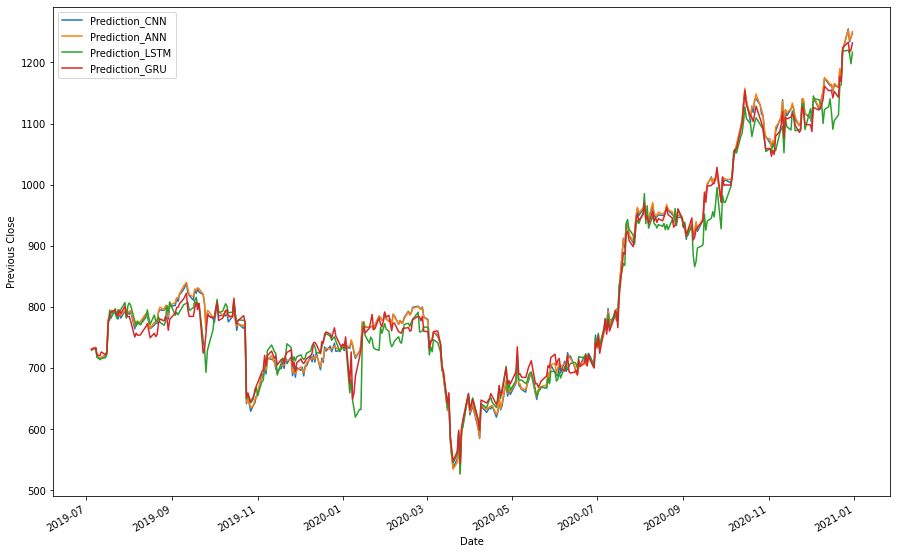

In [44]:
df[[ 'Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10),
    ylabel=("Previous Close"));

Evaluation

In [45]:
pred_ann=df['Prediction_ANN']
pred_ann.dropna(inplace=True)

In [46]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_ann))
print(rmse)

18.21332651837978


In [47]:
error=mean_absolute_error(test['Prev Close'],pred_ann)
print(error)

12.276550735280194


In [48]:
r2_score(test['Prev Close'],pred_ann)

0.9879150578626138

In [49]:
pred_cnn=df['Prediction_CNN']
pred_cnn.dropna(inplace=True)

In [50]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_cnn))
print(rmse)

18.83230997965712


In [51]:
error=mean_absolute_error(test['Prev Close'],pred_cnn)
print(error)

12.908532749122445


In [52]:
r2_score(test['Prev Close'],pred_cnn)

0.9870796815921326

In [53]:
pred_lstm=df['Prediction_LSTM']
pred_lstm.dropna(inplace=True)

In [54]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm))
print(rmse)

32.07236427529232


In [55]:
error=mean_absolute_error(test['Prev Close'],pred_lstm)
print(error)

23.817605300544887


In [56]:
r2_score(test['Prev Close'],pred_lstm)

0.9625261787954109

In [57]:
pred_gru=df['Prediction_GRU']
pred_gru.dropna(inplace=True)

In [58]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_gru))
print(rmse)

24.236958295428362


In [59]:
error=mean_absolute_error(test['Prev Close'],pred_gru)
print(error)

17.84556283142689


In [60]:
r2_score(test['Prev Close'],pred_gru)

0.9785995818348481